# AI 4 StoryLines - Intro

In [1]:
import autoroot
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import xee
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Covariates

In [2]:
!ls /pool/usuarios/tanea/data/storylines/CMIP6/

data-storylines.csv	    sm_sur  t2m   tmax95    z500
data-storylines_readme.txt  sst     tmax  tmax_std


In [3]:
data_dir_x = "/pool/usuarios/tanea/data/storylines/CMIP6/data-storylines.csv"

In [4]:
# open file
df = pd.read_csv(data_dir_x, index_col=0)

# remove extra columns (stats, region)
df = df.drop(columns=["stand","norm", "region"])

# pivot table to make columns vectors
df = df.pivot(columns=["variable"], index=["model"], values="value").reset_index()

# clean - rename variables
df["model"] = df["model"].apply(lambda x: x.replace(".","_"))
df = df.rename(columns={"z500.zonal": "z500", "sm_sur": "sm"})

# normalize 
df["sst_norm"] = df["sst"] / df["t2m"]
df["sm_norm"] = df["sm"] / df["t2m"]
df["z500_norm"] = df["z500"] / df["t2m"]

# 

# print some stats
df.describe()

variable,sm,sst,t2m,z500,sst_norm,sm_norm,z500_norm
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,-2.669220,4.331745,3.884549,3.698631,1.128507,-0.717678,1.159071
std,0.978925,1.083684,0.928355,4.644755,0.191096,0.311227,1.373765
min,-5.437325,2.438398,2.233095,-5.698894,0.854598,-1.917307,-1.212356
25%,-3.118519,3.724622,3.146258,1.840159,0.971089,-0.803555,0.326556
50%,-2.491407,4.286376,3.894319,4.438803,1.090096,-0.685246,1.076654
75%,-1.927398,4.761556,4.432242,5.769861,1.212381,-0.556713,1.881992
max,-1.368886,7.135664,5.841228,11.555147,1.536987,-0.330490,3.986400


In [5]:
df_subset = df[["sm_norm", "sst_norm", "z500_norm", "model"]]
df_subset

variable,sm_norm,sst_norm,z500_norm,model
0,-0.443574,1.003800,-1.098210,access_cm2
1,-0.415504,1.105358,0.855116,access_esm1_5
2,-0.762372,1.165122,3.578246,bcc_csm2_mr
3,-0.775614,1.344161,2.997851,cams_csm1_0
4,-0.466447,1.209306,0.132129,canesm5
5,-0.339785,1.074641,1.307018,cmcc_esm2
6,-0.630988,0.937612,1.177976,cnrm_cm6_1
7,-0.697477,0.973961,1.022944,cnrm_cm6_1_hr
8,-0.623312,0.931786,1.092076,cnrm_esm2_1
9,-0.337992,1.221603,0.379060,e3sm_1_0


## Exploratory Data Analysis

#### Model Scatter Plot 

Below, we show a scatter plot for the different models.

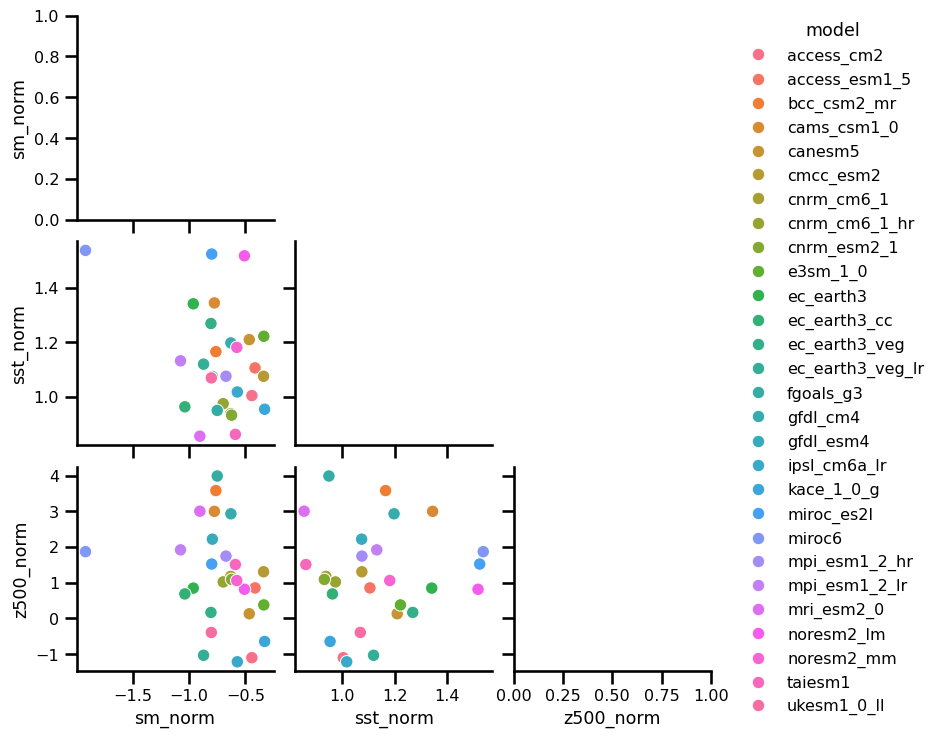

In [6]:
sns.pairplot(df[["sm_norm", "sst_norm", "z500_norm", "model"]], hue="model", diag_kind="", corner=True)

#### PairPlot - Variables

We assume that the models are independent, so we can ignore the color scheme for now. 
Now, we will look at a pair plot using different representations:
1) the histograms of each of the covariates
2) a simple regression plot between the variables
3) a joint density plot for each of the pairs of variables

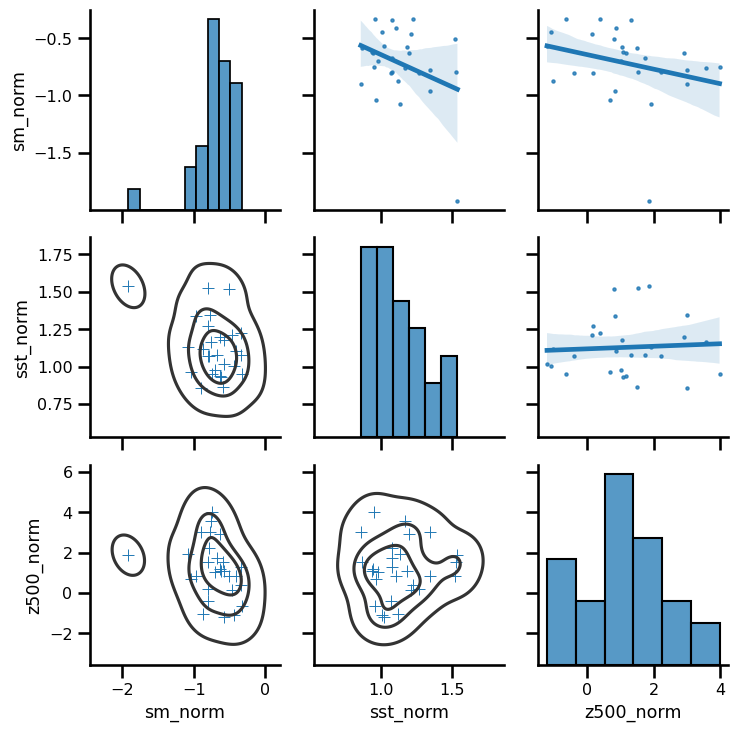

In [7]:
g = sns.pairplot(df[["sm_norm", "sst_norm", "z500_norm", "model"]], kind="", diag_kind="",)
g.map_diag(sns.histplot, cumulative=False, fill=True)
g.map_upper(sns.regplot, scatter_kws=dict(marker="+", s=5))
g.map_lower(sns.scatterplot,  marker="+", s=75)
g.map_lower(sns.kdeplot, levels=4, color=".2", )
plt.show()

## Quantity of Interest

In [8]:
data_dir_u = "/pool/usuarios/tanea/data/storylines/CMIP6/tmax/delta_CC/europe/"

In [9]:
!ls $data_dir_u

delta_tmax_access-cm2_JJA-period-mean_europe.nc
delta_tmax_access-esm1-5_JJA-period-mean_europe.nc
delta_tmax_bcc-csm2-mr_JJA-period-mean_europe.nc
delta_tmax_cams-csm1-0_JJA-period-mean_europe.nc
delta_tmax_canesm5_JJA-period-mean_europe.nc
delta_tmax_cmcc-esm2_JJA-period-mean_europe.nc
delta_tmax_cnrm-cm6-1-hr_JJA-period-mean_europe.nc
delta_tmax_cnrm-cm6-1_JJA-period-mean_europe.nc
delta_tmax_cnrm-esm2-1_JJA-period-mean_europe.nc
delta_tmax_e3sm-1-0_JJA-period-mean_europe.nc
delta_tmax_ec-earth3-cc_JJA-period-mean_europe.nc
delta_tmax_ec-earth3_JJA-period-mean_europe.nc
delta_tmax_ec-earth3-veg_JJA-period-mean_europe.nc
delta_tmax_ec-earth3-veg-lr_JJA-period-mean_europe.nc
delta_tmax_fgoals-g3_JJA-period-mean_europe.nc
delta_tmax_gfdl-cm4_JJA-period-mean_europe.nc
delta_tmax_gfdl-esm4_JJA-period-mean_europe.nc
delta_tmax_ipsl-cm6a-lr_JJA-period-mean_europe.nc
delta_tmax_kace-1-0-g_JJA-period-mean_europe.nc
delta_tmax_miroc6_JJA-period-mean_europe.nc
delta_tmax_miroc-es2l_JJA-period-

Let's grab all of the files within the data directory.
We will also parse only the files that are of europe

In [10]:
# get all files
list_of_files = get_list_filenames(data_dir_u, "*.nc")
# only select europe
list_of_files = list(filter(lambda x: "mean_europe" in x, list_of_files))
len(list_of_files)

28

Overall, we have 28 model realizations.

In [11]:
ds = xr.open_dataset(list_of_files[0], engine="netcdf4")
ds

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 1, lon: 21, lat: 19)
Coordinates:
  * time     (time) datetime64[ns] 8B 2100-07-17
  * lon      (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 22.5 25.0 27.5 30.0
  * lat      (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
    height   float64 8B ...
Data variables:
    tasmax   (time, lat, lon) float32 2kB ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

### Preprocessing

We need to do a little cleaning of the data.

* Drop Irrelevant Indices
* Rename some variables
* Add relevant dimensions
* Subset region
* Add Land-Mask

In [12]:
from datetime import datetime
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask
import numpy as np

def preprocess(ds: xr.Dataset) -> xr.Dataset:    
    # remove excess variables
    ds = ds.drop_vars(["height", "time"])
    
    # assign variable names
    ds["tasmax"] = ds["tasmax"].squeeze()
    model_name = ds.attrs["source_id"].lower().replace("-","_")
    ds["tasmax"] = ds.tasmax.expand_dims({"model": [np.asarray(model_name).astype(np.unicode_)]})

    # select europe only
    ds = ds.sel(lon=slice(-20, 30), lat=slice(26, 72))

    # add land mask
    mask = add_land_mask(ds.copy())["land_mask"]
    ds = ds.assign_coords({"land_mask": mask})
    ds = ds.drop_vars(["region", "abbrevs", "names"])
    return ds

We will test the preprocessing script on a single file to make sure it is clean.

In [13]:
ds = xr.open_dataset(list_of_files[0], decode_times=False)
ds = preprocess(ds)
ds

<xarray.Dataset> Size: 3kB
Dimensions:    (lon: 21, lat: 19, model: 1)
Coordinates:
  * lon        (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat        (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
  * model      (model) object 8B 'access_cm2'
    land_mask  (lat, lon) int16 798B 0 0 0 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    tasmax     (model, lat, lon) float32 2kB 3.244 2.818 2.714 ... 6.929 7.456
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

Now, we can apply the same function for multiple files.

In [14]:
ds = xr.open_mfdataset(
    list_of_files, 
    preprocess=preprocess, 
    combine="nested", 
    concat_dim="model"
)
ds

<xarray.Dataset> Size: 46kB
Dimensions:    (lon: 21, lat: 19, model: 28)
Coordinates:
  * lon        (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat        (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
  * model      (model) object 224B 'access_cm2' ... 'ukesm1_0_ll'
    land_mask  (lat, lon) int16 798B 0 0 0 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    tasmax     (model, lat, lon) float32 45kB dask.array<chunksize=(1, 19, 21), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

In [15]:
ds["tasmax_norm"] = ds["tasmax"] / df["t2m"].values[:, None, None]

#### Viz - Different Models

We can visualize different realizations to show the spread of the points.

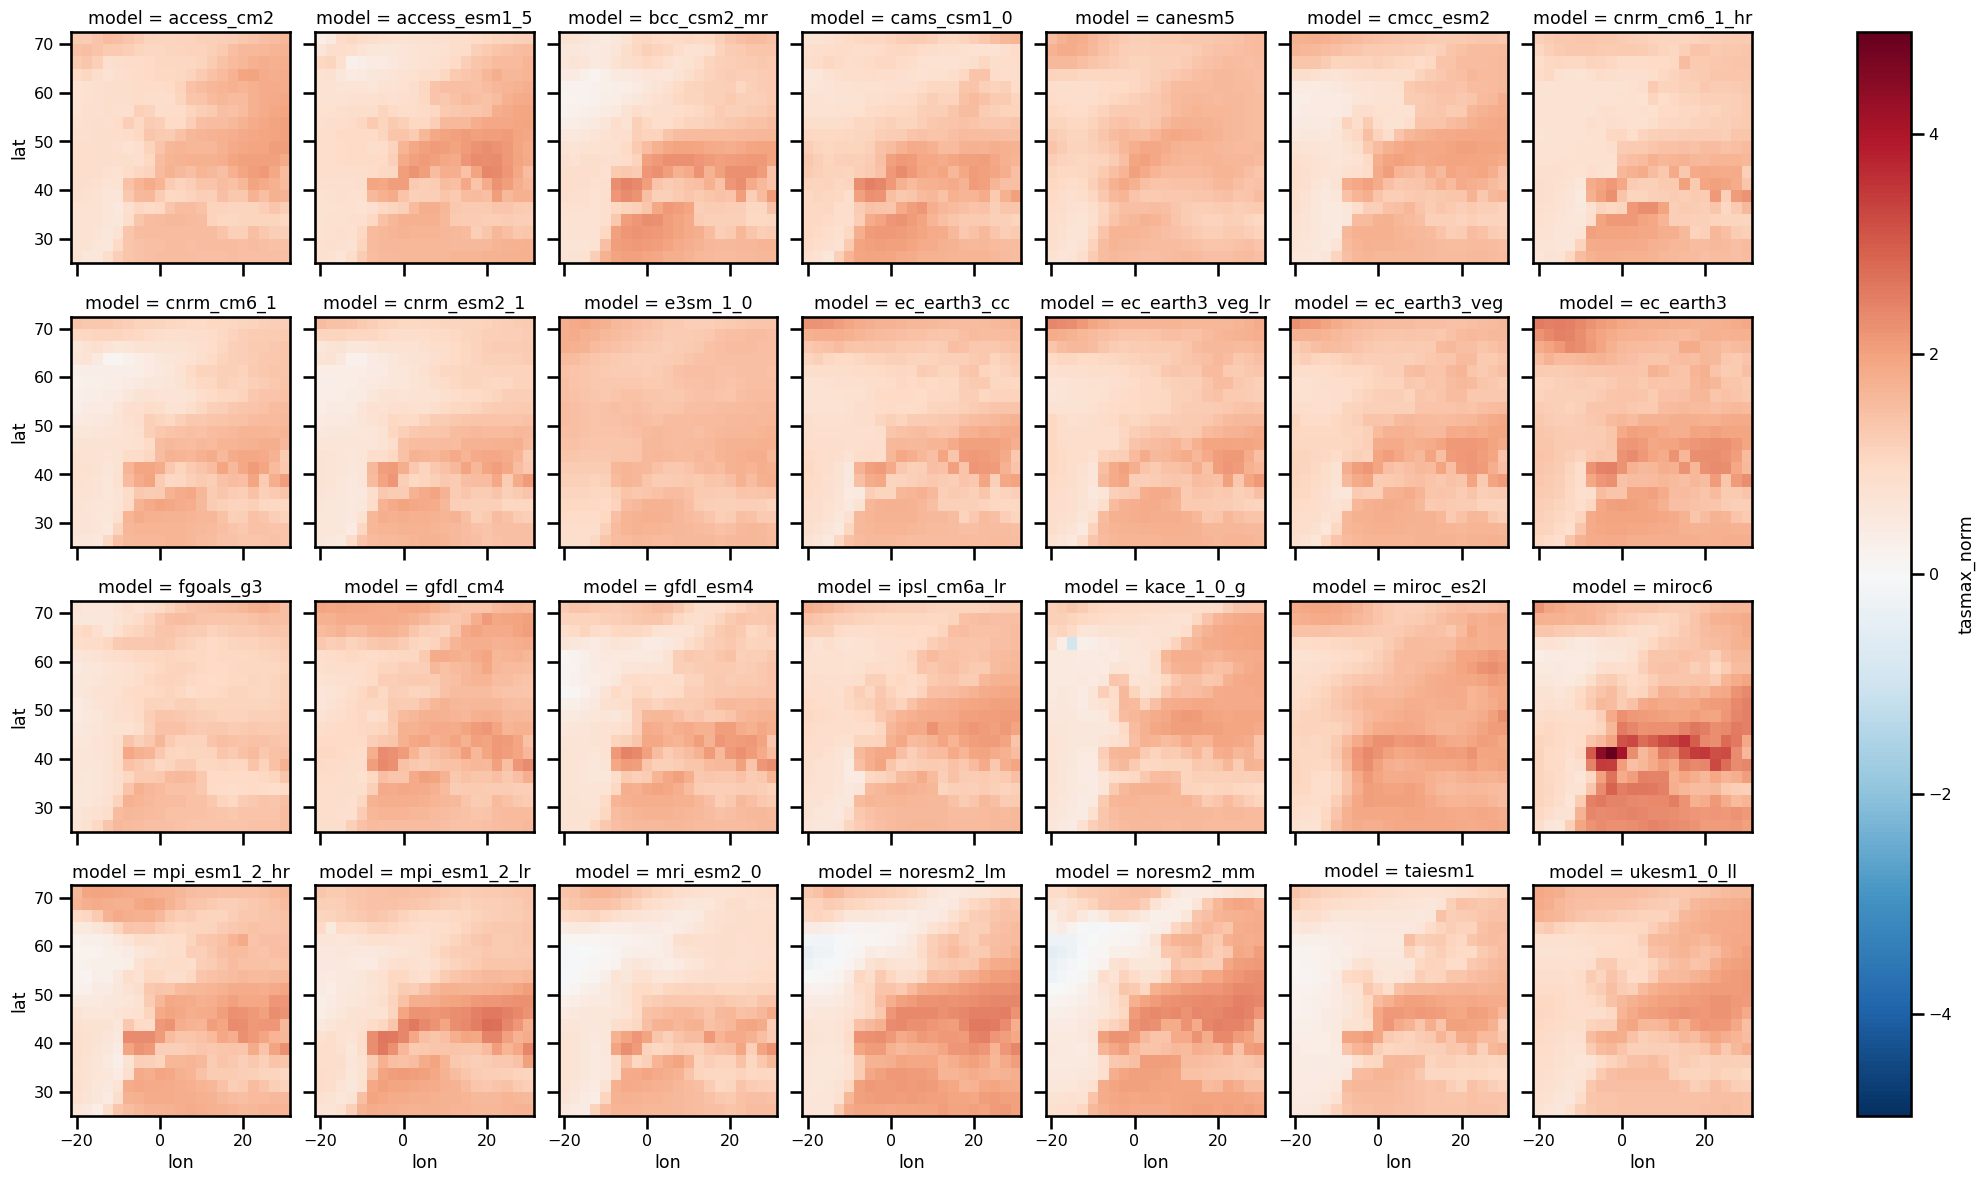

In [16]:
ds.tasmax_norm.plot(col="model", col_wrap=7)
plt.show()

#### Viz - Statistics

We can also showcase the summary statistics of the different models, i.e., the mean and the variance.

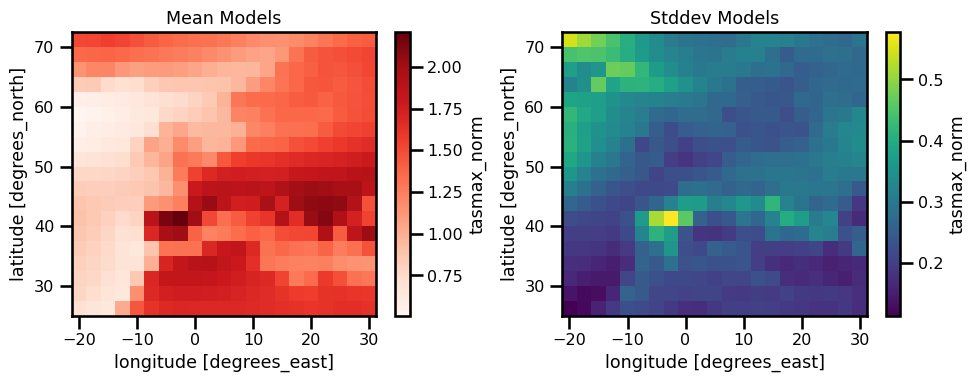

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ds.mean(dim=["model"]).tasmax_norm.plot.pcolormesh(ax=ax[0], cmap="Reds")
ds.std(dim=["model"]).tasmax_norm.plot.pcolormesh(ax=ax[1], cmap="viridis")

ax[0].set(title="Mean Models")
ax[1].set(title="Stddev Models")

plt.tight_layout()
plt.show()

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Relationship

In [27]:
models = ['access_cm2', 'access_esm1_5', 'bcc_csm2_mr', 'cams_csm1_0', 'canesm5',
       'cmcc_esm2', 'cnrm_cm6_1', 'cnrm_cm6_1_hr', 'cnrm_esm2_1', 'e3sm_1_0',
       'ec_earth3', 'ec_earth3_cc', 'ec_earth3_veg', 'ec_earth3_veg_lr',
       'fgoals_g3', 'gfdl_cm4', 'gfdl_esm4', 'ipsl_cm6a_lr', 'kace_1_0_g',
       'miroc_es2l', 'mpi_esm1_2_hr', 'mpi_esm1_2_lr', 'mri_esm2_0',
       'noresm2_lm', 'noresm2_mm', 'taiesm1', 'ukesm1_0_ll']

# only select valid models
ds_subset = ds.sel(model=models)
df_subset = df[df["model"].map(lambda x: x in models)]

In [78]:
ds = xr.merge([ds, df.set_index("model").to_xarray()])
ds

<xarray.Dataset> Size: 137kB
Dimensions:      (lon: 21, lat: 19, model: 28)
Coordinates:
  * lon          (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat          (lat) float64 152B 26.25 28.75 31.25 ... 66.25 68.75 71.25
  * model        (model) object 224B 'access_cm2' ... 'ukesm1_0_ll'
    land_mask    (lat, lon) int16 798B 0 0 0 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
Data variables:
    tasmax       (model, lat, lon) float32 45kB dask.array<chunksize=(1, 19, 21), meta=np.ndarray>
    tasmax_norm  (model, lat, lon) float64 89kB dask.array<chunksize=(1, 19, 21), meta=np.ndarray>
    sm           (model) float64 224B -2.036 -1.579 -2.462 ... -2.89 -4.523
    sst          (model) float64 224B 4.607 4.202 3.763 ... 3.729 4.222 6.022
    t2m          (model) float64 224B 4.589 3.801 3.229 ... 3.158 4.902 5.635
    z500         (model) float64 224B -5.04 3.251 11.56 ... 3.351 7.399 -2.207
    sst_norm     (model) float64 224B 1.004 1.105 1.165 ... 1.181 0.8612 1.069
    sm_norm      (model) float64 224B -0.4436 -0.4155 ... -0.5896 -0.8027
    z500_norm    (model) float64 224B -1.098 0.8551 3.578 ... 1.509 -0.3918
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

In [112]:
subset = ds[["tasmax_norm", "sst_norm", "sm_norm", "z500_norm"]].stack(spatial=["lat", "lon"])
subset = subset.drop_vars(["spatial", "lon", "lat"]).assign_coords({"spatial": np.arange(1,len(subset.spatial)+1)})
subset = subset.to_dataframe().reset_index()
subset

,model,spatial,tasmax_norm,sst_norm,sm_norm,z500_norm,land_mask
0,access_cm2,1,0.706911,1.003800,-0.443574,-1.098210,0
1,access_cm2,2,0.614053,1.003800,-0.443574,-1.098210,0
2,access_cm2,3,0.591324,1.003800,-0.443574,-1.098210,0
3,access_cm2,4,0.882698,1.003800,-0.443574,-1.098210,1
4,access_cm2,5,1.213717,1.003800,-0.443574,-1.098210,1
...,...,...,...,...,...,...,...
11167,ukesm1_0_ll,395,1.403165,1.068734,-0.802712,-0.391769,0
11168,ukesm1_0_ll,396,1.472453,1.068734,-0.802712,-0.391769,0
11169,ukesm1_0_ll,397,1.541903,1.068734,-0.802712,-0.391769,0
11170,ukesm1_0_ll,398,1.587436,1.068734,-0.802712,-0.391769,0


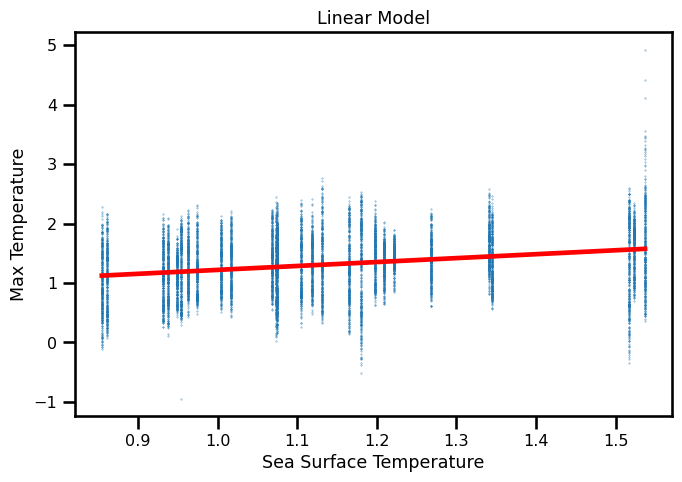

In [144]:
fig, ax = plt.subplots(ncols=1, figsize=(7,5))

sns.regplot(
    subset, x="sst_norm", y="tasmax_norm", ax=ax, logx=False, 
    scatter_kws=dict(s=0.1), line_kws=dict(color="r")
)

ax.set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Linear Model")

plt.tight_layout()
plt.show()

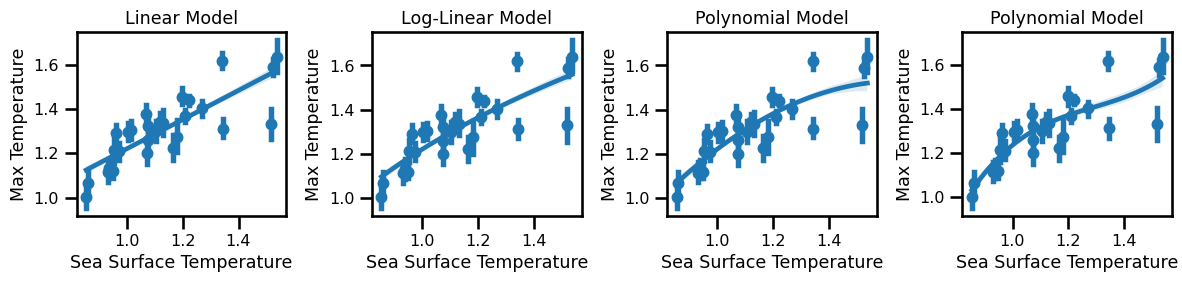

In [130]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.mean, ax=ax[0], logx=False)
sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.mean, ax=ax[1], logx=True)
sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.mean, ax=ax[2], order=2)
sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.mean, ax=ax[3], order=3)

ax[0].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Linear Model")
ax[1].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Log-Linear Model")
ax[2].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Polynomial Model")
ax[3].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Polynomial Model")

plt.tight_layout()
plt.show()

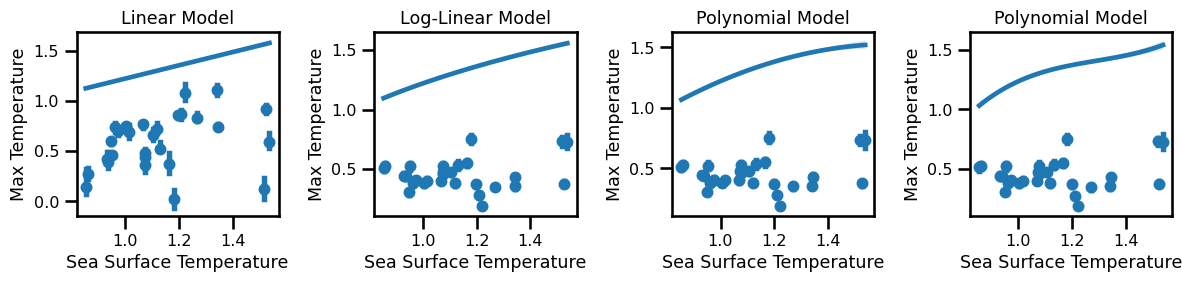

In [141]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))
from functools import partial

sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=partial(np.quantile, q=0.05), ax=ax[0], logx=False)
sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.std, ax=ax[1], logx=True)
sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.std, ax=ax[2], order=2)
sns.regplot(subset, x="sst_norm", y="tasmax_norm", x_estimator=np.std, ax=ax[3], order=3)

ax[0].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Linear Model")
ax[1].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Log-Linear Model")
ax[2].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Polynomial Model")
ax[3].set(xlabel="Sea Surface Temperature", ylabel="Max Temperature", title="Polynomial Model")

plt.tight_layout()
plt.show()

In [ ]:
sns.regplot(data=df_subset, x=")

In [38]:
u_qs = ds_subset.tasmax_norm.quantile(q=[0.05, 0.5, 0.95], dim=["lat", "lon"])
# u_mean.shape, df_subset

### Mean

#### Linear Regression 

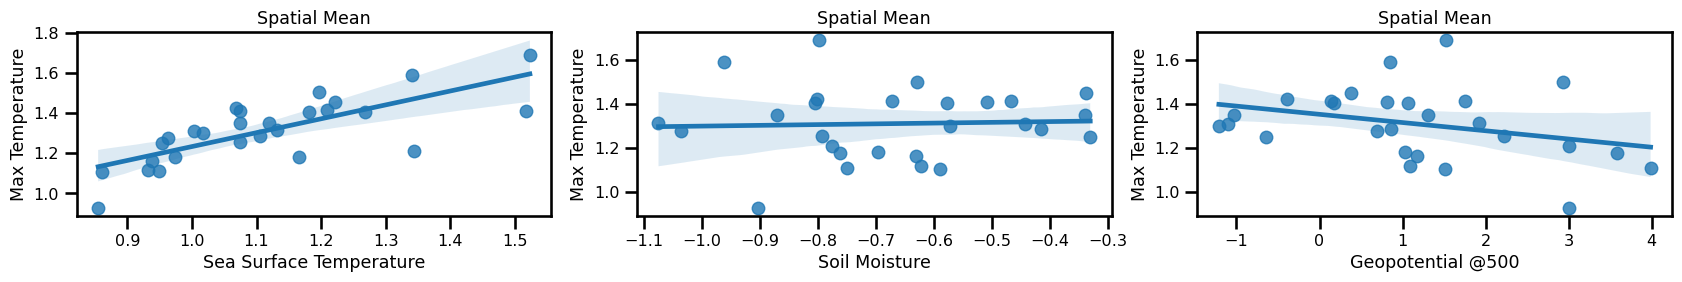

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(17,3))

# plot the mean
sns.regplot(ax=ax[0], x=df_subset[["sst_norm"]].values, y=u_qs.sel(quantile=0.5))
sns.regplot(ax=ax[1], x=df_subset[["sm_norm"]].values, y=u_qs.sel(quantile=0.5))
sns.regplot(ax=ax[2], x=df_subset[["z500_norm"]].values, y=u_qs.sel(quantile=0.5))

ax[0].set(
    xlabel="Sea Surface Temperature",
    ylabel="Max Temperature",
    title="Spatial Mean"
)
ax[1].set(
    xlabel="Soil Moisture",
    ylabel="Max Temperature",
    title="Spatial Mean"
)
ax[2].set(
    xlabel="Geopotential @500",
    ylabel="Max Temperature",
    title="Spatial Mean"
)

plt.tight_layout()
plt.show()

#### Polynomial Regression

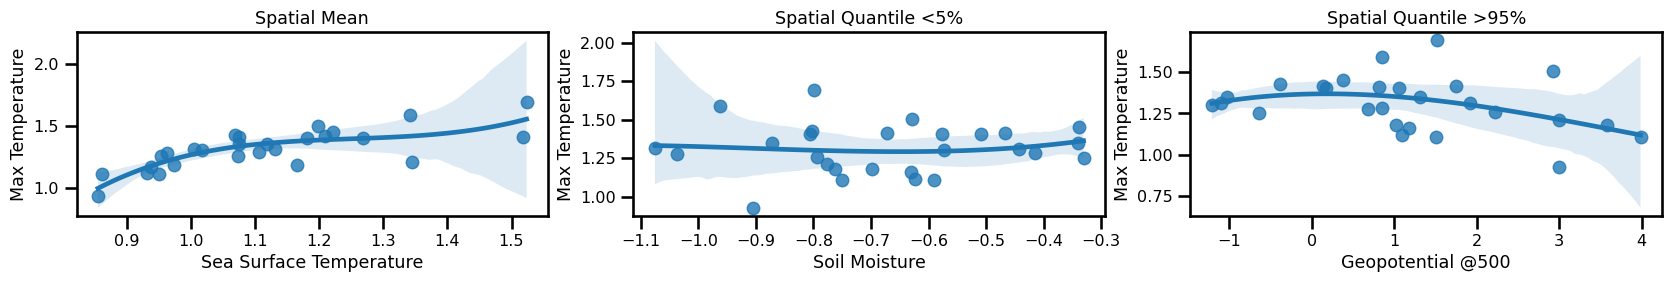

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(17,3))

# plot the mean
sns.regplot(ax=ax[0], x=df_subset[["sst_norm"]].values, y=u_qs.sel(quantile=0.5), order=3)
sns.regplot(ax=ax[1], x=df_subset[["sm_norm"]].values, y=u_qs.sel(quantile=0.5), order=3)
sns.regplot(ax=ax[2], x=df_subset[["z500_norm"]].values, y=u_qs.sel(quantile=0.5), order=3)

ax[0].set(
    xlabel="Sea Surface Temperature",
    ylabel="Max Temperature",
    title="Spatial Mean"
)
ax[1].set(
    xlabel="Soil Moisture",
    ylabel="Max Temperature",
    title="Spatial Mean"
)
ax[2].set(
    xlabel="Geopotential @500",
    ylabel="Max Temperature",
    title="Spatial Mean"
)

plt.tight_layout()
plt.show()

### Quantile, <5%

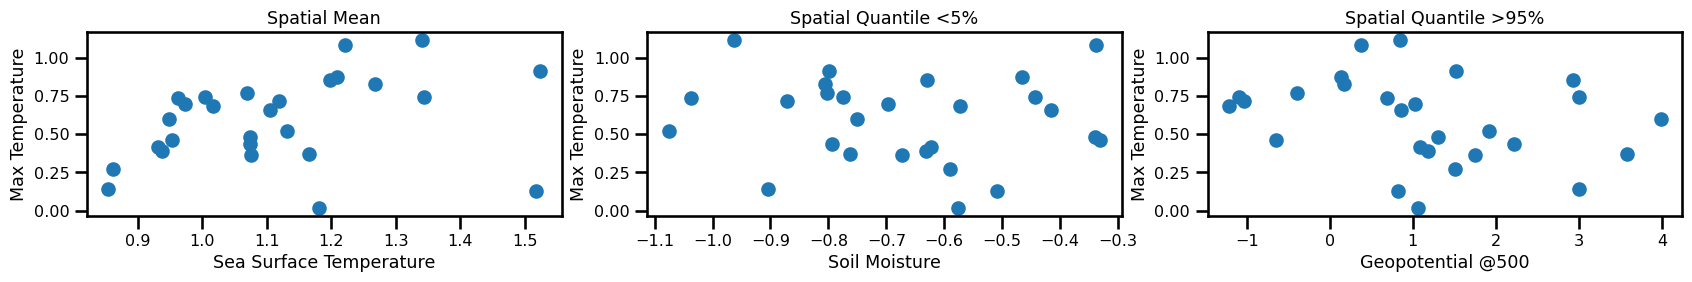

In [56]:
fig, ax = plt.subplots(ncols=3, figsize=(17,3))

# plot the mean
ax[0].scatter(df_subset[["sst_norm"]].values, u_qs.sel(quantile=0.05))
ax[1].scatter(df_subset[["sm_norm"]].values, u_qs.sel(quantile=0.05))
ax[2].scatter(df_subset[["z500_norm"]].values, u_qs.sel(quantile=0.05))

ax[0].set(
    xlabel="Sea Surface Temperature",
    ylabel="Max Temperature",
    title="Spatial Mean"
)
ax[1].set(
    xlabel="Soil Moisture",
    ylabel="Max Temperature",
    title="Spatial Quantile <5%"
)
ax[2].set(
    xlabel="Geopotential @500",
    ylabel="Max Temperature",
    title="Spatial Quantile >95%"
)

plt.tight_layout()
plt.show()

### Quantile, <95%

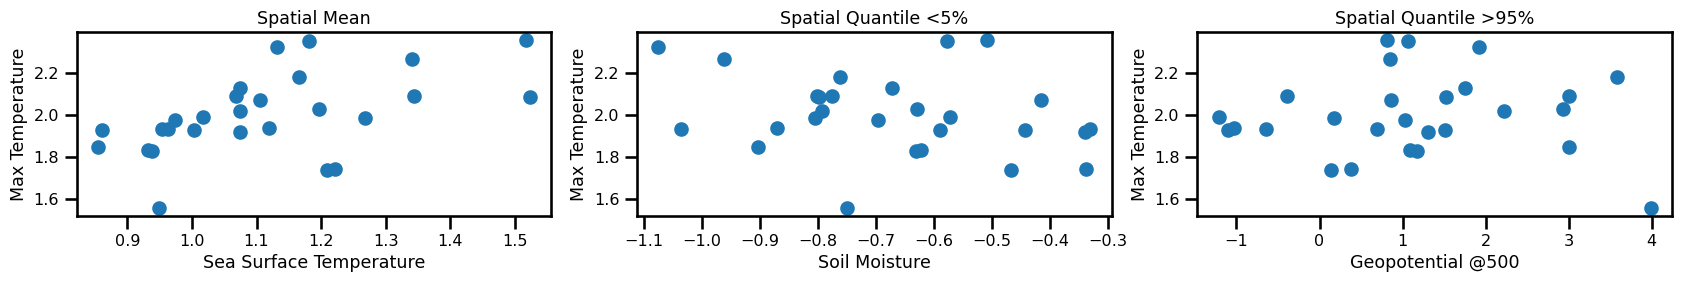

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(17,3))

# plot the mean
ax[0].scatter(df_subset[["sst_norm"]].values, u_qs.sel(quantile=0.95))
ax[1].scatter(df_subset[["sm_norm"]].values, u_qs.sel(quantile=0.95))
ax[2].scatter(df_subset[["z500_norm"]].values, u_qs.sel(quantile=0.95))

ax[0].set(
    xlabel="Sea Surface Temperature",
    ylabel="Max Temperature",
    title="Spatial Mean"
)
ax[1].set(
    xlabel="Soil Moisture",
    ylabel="Max Temperature",
    title="Spatial Quantile <5%"
)
ax[2].set(
    xlabel="Geopotential @500",
    ylabel="Max Temperature",
    title="Spatial Quantile >95%"
)

plt.tight_layout()
plt.show()

## Save Data

We have a clean analysis-ready dataset available.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [18]:
assert df.model.values.sort() == ds.model.values.sort()

Now, we can save the data

In [19]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [20]:
df.to_csv(Path(save_dir).joinpath("covariates.csv"))
ds.to_netcdf(Path(save_dir).joinpath("qoi.nc"))